In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("/home/yufan")  # parent of `perturbgene` directory

import json
import os
import pickle

import matplotlib.pyplot as plt
import numpy as np
import scipy
import torch
import transformers
from tqdm import tqdm  # https://discuss.pytorch.org/t/error-while-multiprocessing-in-dataloader/46845/9
from braceexpand import braceexpand
from perturbgene.data_utils import GeneTokenizer, IterableAnnDataset, EvalJsonDataset, read_h5ad_file
from perturbgene.data_utils.data_collators import collate_fn_wrapper
from perturbgene.data_utils.tokenization import _prepend_bin, phenotype_to_token
from perturbgene.eval_utils import mlm_metrics_wrapper, cls_metrics_wrapper, preprocess_logits_argmax
from perturbgene.model import GeneBertForPhenotypicMLM, GeneBertForClassification, GeneBertModel
from perturbgene.inference_utils import get_inference_config, prepare_cell, test_cell, mlm_for_phenotype_cls

/home/yufan/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [32]:
import torch
import numpy as np

In [39]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Choose one of the methods for dimensionality reduction

# PCA
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(mean_embeddings)

# or t-SNE
# tsne = TSNE(n_components=2, random_state=42)
# reduced_embeddings = tsne.fit_transform(mean_embeddings)

print("Shape of reduced embeddings:", reduced_embeddings.shape)

Shape of reduced embeddings: (3007, 2)


In [52]:
labels = validation_data.obs.compartment[:3007].to_list()

In [54]:
validation_data[:100].obs

,tissue_in_publication,assay_ontology_term_id,donor_id,anatomical_information,n_counts_UMIs,n_genes,cell_ontology_class,free_annotation,manually_annotated,compartment,...,tissue_type,cell_type,assay,disease,organism,sex,tissue,self_reported_ethnicity,development_stage,observation_joinid
TCATGAGCATTCAGCA_TSP8_Blood_NA_10X_1_1,Blood,EFO:0009922,TSP8,nan,7255.0,1748,"cd4-positive, alpha-beta memory t cell","cd4-positive, alpha-beta memory t cell",True,immune,...,tissue,"CD4-positive, alpha-beta memory T cell",10x 3' v3,normal,Homo sapiens,male,blood,Hispanic or Latin American,56-year-old human stage,?7jT<Bex3K
TTACGTTCAAGCACCC_TSP2_Trachea_NA_10X_1_1,Trachea,EFO:0009922,TSP2,nan,19285.0,4469,basal cell,basal cell,True,epithelial,...,tissue,basal cell,10x 3' v3,normal,Homo sapiens,female,trachea,African American or Afro-Caribbean,61-year-old human stage,o{}|6`4{Aq
GCCATGGAGCACTGGA_TSP7_LymphNodes_Inguinal_10X_1_1,Lymph_Node,EFO:0009922,TSP7,inguinal,7485.0,1938,b cell,B cell,True,immune,...,tissue,B cell,10x 3' v3,normal,Homo sapiens,female,inguinal lymph node,European,69-year-old human stage,=dwFpiW<g!
ATGACCACACCCATAA_TSP7_Blood_NA_10X_1_1,Blood,EFO:0009922,TSP7,nan,17101.0,4003,classical monocyte,classical monocyte,True,immune,...,tissue,classical monocyte,10x 3' v3,normal,Homo sapiens,female,blood,European,69-year-old human stage,a?yXpXxB_c
GCTCCTAGTTCAGTAC_TSP14_LymphNode_NA_10X_2_1_5Prime,Lymph_Node,EFO:0030004,TSP14,nan,3454.0,1559,cd8-positive alpha-beta t cell,CD8-positive alpha-beta thymocyte,True,immune,...,tissue,"effector CD8-positive, alpha-beta T cell",10x 5' transcription profiling,normal,Homo sapiens,male,lymph node,European,59-year-old human stage,w%fPX#!Q}}
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGGATAGTTATAGAG_TSP2_Lung_proxmedialdistal_10X_1_1,Lung,EFO:0009922,TSP2,proxmedialdistal,2857.0,1262,"cd4-positive, alpha-beta t cell","cd4-positive, alpha-beta t cell",True,immune,...,tissue,"CD4-positive, alpha-beta T cell",10x 3' v3,normal,Homo sapiens,female,lung,African American or Afro-Caribbean,61-year-old human stage,L-hKm=oC&(
ACGGTTACAAGCGATG_TSP2_Trachea_NA_10X_1_2,Trachea,EFO:0009922,TSP2,nan,11741.0,3036,basal cell,basal cell,True,epithelial,...,tissue,basal cell,10x 3' v3,normal,Homo sapiens,female,trachea,African American or Afro-Caribbean,61-year-old human stage,3BR<fN>w}?
CGGAACCCATTGAGCT_TSP8_Prostate_NA_10X_1_1,Prostate,EFO:0009922,TSP8,nan,5226.0,1620,epithelial cell,Other Epithelial Cell,True,epithelial,...,tissue,epithelial cell,10x 3' v3,normal,Homo sapiens,male,prostate gland,Hispanic or Latin American,56-year-old human stage,+fi>*w`D?<
AAGGTTCAGTCAAGGC_TSP14_LymphNode_NA_10X_2_1_5Prime,Lymph_Node,EFO:0030004,TSP14,nan,3595.0,1408,cd4-positive alpha-beta t cell,CD4-positive alpha-beta thymocyte,True,immune,...,tissue,"effector CD4-positive, alpha-beta T cell",10x 5' transcription profiling,normal,Homo sapiens,male,lymph node,European,59-year-old human stage,G+X9JE=<TD


In [56]:
config

TrainMLMConfig(subcommand='mlm', bin_edges=[0.1, 1.08888889, 2.07777778, 3.06666667, 4.05555556, 5.04444444, 6.03333333, 7.02222222, 8.01111111, 9.0], bin_edges_path=None, pretrained_model_path='perturbgene/model_configs/distilbert_large.json', model_arch=None, shard_size=10000, eval_data_paths=['perturbgene/ranked/Tabula_Sapiens_ranked_47.h5ad'], max_length=10000, num_top_genes=58604, vocab_path='/home/yufan/perturbgene/data/phenotypic_tokens_map.json', included_phenotypes=['cell_type', 'sex', 'tissue'], use_flash_attn=True, output_dir='output_2gpu_mlm_015gene_050pheno_vastai', per_device_eval_batch_size=32, dataloader_num_workers=4, auto_find_batch_size=True, train_data_paths=['perturbgene/ranked/Tabula_Sapiens_ranked_0.h5ad', 'perturbgene/ranked/Tabula_Sapiens_ranked_1.h5ad', 'perturbgene/ranked/Tabula_Sapiens_ranked_2.h5ad', 'perturbgene/ranked/Tabula_Sapiens_ranked_3.h5ad', 'perturbgene/ranked/Tabula_Sapiens_ranked_4.h5ad', 'perturbgene/ranked/Tabula_Sapiens_ranked_5.h5ad', 'pertu

In [55]:
model

GeneBertModel(
  (embeddings): PositionlessEmbeddings(
    (word_embeddings): Embedding(268, 1024, padding_idx=3)
    (token_type_embeddings): Embedding(58610, 1024)
    (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0-11): 12 x TransformerBlock(
        (attention): MultiHeadSelfAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=1024, out_features=1024, bias=True)
          (k_lin): Linear(in_features=1024, out_features=1024, bias=True)
          (v_lin): Linear(in_features=1024, out_features=1024, bias=True)
          (out_lin): Linear(in_features=1024, out_features=1024, bias=True)
        )
        (sa_layer_norm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=1024, out_features=3072, bias

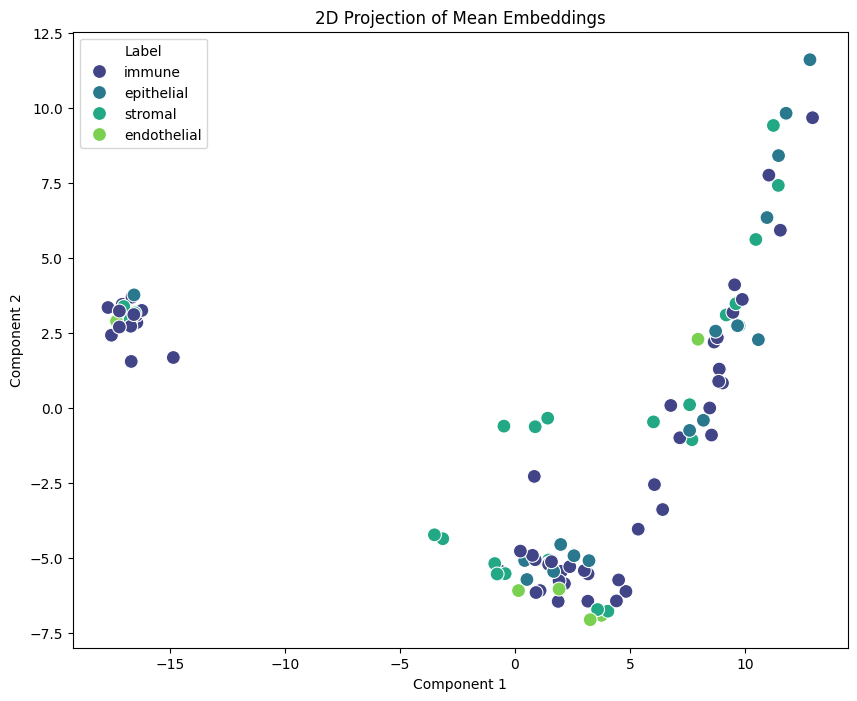

In [53]:
import seaborn as sns
import pandas as pd
df = pd.DataFrame({
    'Component 1': reduced_embeddings[:100, 0],
    'Component 2': reduced_embeddings[:100, 1],
    'Label': labels[:100]
})

# Plot using seaborn
plt.figure(figsize=(10, 8))
sns.scatterplot(x='Component 1', y='Component 2', hue='Label', palette='viridis', data=df, s=100)
plt.title('2D Projection of Mean Embeddings')
plt.show()

In [2]:
model_checkpt_path = "/storage_bizon/bizon_filesystem/output_2gpu_mlm_015gene_050pheno_vastai_10000_mlm_bins10/checkpoint-305000"

device = "cuda:0"

# Load tokenizer first, so that we can get the config
expected_tokenizer_path = os.path.join(
    os.path.dirname(model_checkpt_path),
    "tokenizer.pkl",
)

if os.path.isfile(expected_tokenizer_path):
    with open(expected_tokenizer_path, "rb") as f:
        tokenizer = pickle.load(f)
else:
    print("Saved tokenizer not found, creating tokenizer with common parameters")
    tokenizer = GeneTokenizer(get_inference_config(  # change these parameters
        bin_edges=[0.1], 
        pretrained_model_path=model_checkpt_path,  # needs to be a path that exists
        max_length=130,        
        num_top_genes=128
    ))

In [3]:
tokenizer.config.vocab_path = os.path.join("/home/yufan/", tokenizer.config.vocab_path)  # rel path -> abs path
config = tokenizer.config

In [15]:
model_checkpt_path = "/storage_bizon/bizon_filesystem/output_2gpu_mlm_015gene_050pheno_vastai_10000_mlm_bins10/checkpoint-305000"

device = "cuda:0"

# Load tokenizer first, so that we can get the config
expected_tokenizer_path = os.path.join(
    os.path.dirname(model_checkpt_path),
    "tokenizer.pkl",
)

if os.path.isfile(expected_tokenizer_path):
    with open(expected_tokenizer_path, "rb") as f:
        tokenizer = pickle.load(f)
else:
    print("Saved tokenizer not found, creating tokenizer with common parameters")
    tokenizer = GeneTokenizer(get_inference_config(  # change these parameters
        bin_edges=[0.1], 
        pretrained_model_path=model_checkpt_path,  # needs to be a path that exists
        max_length=130,        
        num_top_genes=128
    ))

tokenizer.config.vocab_path = os.path.join("/home/yufan/", tokenizer.config.vocab_path)  # rel path -> abs path
config = tokenizer.config

model_class = GeneBertModel

data_collator = collate_fn_wrapper(tokenizer)
compute_metrics = cls_metrics_wrapper(tokenizer)  # always using cls_metrics

# Largely copied from IterableAnnDataset
phenotype_category_labels = tokenizer.phenotypic_tokens_map[config.phenotype_category]

if config.binary_label is None:
    label2id = {label: i for i, label in enumerate(phenotype_category_labels)}
else:
    label2id = {label: int(label == config.binary_label)
                     for label in phenotype_category_labels}

AttributeError: 'TrainMLMConfig' object has no attribute 'phenotype_category'

In [39]:
config

TrainMLMConfig(subcommand='mlm', bin_edges=[0.1, 1.08888889, 2.07777778, 3.06666667, 4.05555556, 5.04444444, 6.03333333, 7.02222222, 8.01111111, 9.0], bin_edges_path=None, pretrained_model_path='perturbgene/model_configs/distilbert_large.json', model_arch=None, shard_size=10000, eval_data_paths=['perturbgene/ranked/Tabula_Sapiens_ranked_47.h5ad'], max_length=10000, num_top_genes=58604, vocab_path='/home/yufan/perturbgene/data/phenotypic_tokens_map.json', included_phenotypes=['cell_type', 'sex', 'tissue'], use_flash_attn=True, output_dir='output_2gpu_mlm_015gene_050pheno_vastai', per_device_eval_batch_size=32, dataloader_num_workers=4, auto_find_batch_size=True, train_data_paths=['perturbgene/ranked/Tabula_Sapiens_ranked_0.h5ad', 'perturbgene/ranked/Tabula_Sapiens_ranked_1.h5ad', 'perturbgene/ranked/Tabula_Sapiens_ranked_2.h5ad', 'perturbgene/ranked/Tabula_Sapiens_ranked_3.h5ad', 'perturbgene/ranked/Tabula_Sapiens_ranked_4.h5ad', 'perturbgene/ranked/Tabula_Sapiens_ranked_5.h5ad', 'pertu

In [14]:
model = GeneBertModel.from_pretrained(
    model_checkpt_path
    ).to(device)
model.eval()

GeneBertModel(
  (embeddings): PositionlessEmbeddings(
    (word_embeddings): Embedding(268, 1024, padding_idx=3)
    (token_type_embeddings): Embedding(58610, 1024)
    (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0-11): 12 x TransformerBlock(
        (attention): MultiHeadSelfAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=1024, out_features=1024, bias=True)
          (k_lin): Linear(in_features=1024, out_features=1024, bias=True)
          (v_lin): Linear(in_features=1024, out_features=1024, bias=True)
          (out_lin): Linear(in_features=1024, out_features=1024, bias=True)
        )
        (sa_layer_norm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=1024, out_features=3072, bias

In [4]:
from perturbgene.data_utils.read import read_h5ad_cloudflare

In [8]:
import requests
import anndata

def read_h5ad_cloudflare(file_url: str, local_path: str) -> anndata.AnnData:
    # Send a HEAD request to get the file size
    head_response = requests.head(file_url)
    if head_response.status_code != 200:
        print("Failed to fetch the file headers.")
        return None

    # Get the file size from headers
    file_size = int(head_response.headers.get('Content-Length', 0))
    print(file_size)
    # Check if the file is larger than 10 MB (10 * 1024 * 1024 bytes)
    if file_size > 300 * 1024 * 1024:
        print("File is larger than 10 MB, download skipped.")
        return None

    # Fetch the file if size is within the limit
    response = requests.get(file_url)
    if response.status_code == 200:
        # Write the binary content of the response to a local file
        with open(local_path, 'wb') as f:
            f.write(response.content)
        
        # Load the AnnData object from the saved file
        return anndata.read_h5ad(local_path)
    else:
        print("Failed to fetch the AnnData file.")
        return None

# Example usage
file_url = 'https://pub-8978012207224952a747e641910bcb1c.r2.dev/ranked/Tabula_Sapiens_ranked_47.h5ad'
local_path = 'Tabula_Sapiens_ranked_47.h5ad'
adata = read_h5ad_cloudflare(file_url, local_path)

239432396


In [17]:
validation_data = read_h5ad_file("Tabula_Sapiens_ranked_47.h5ad", config.num_top_genes)

In [21]:
config

TrainMLMConfig(subcommand='mlm', bin_edges=[0.1, 1.08888889, 2.07777778, 3.06666667, 4.05555556, 5.04444444, 6.03333333, 7.02222222, 8.01111111, 9.0], bin_edges_path=None, pretrained_model_path='perturbgene/model_configs/distilbert_large.json', model_arch=None, shard_size=10000, eval_data_paths=['perturbgene/ranked/Tabula_Sapiens_ranked_47.h5ad'], max_length=10000, num_top_genes=58604, vocab_path='/home/yufan/perturbgene/data/phenotypic_tokens_map.json', included_phenotypes=['cell_type', 'sex', 'tissue'], use_flash_attn=True, output_dir='output_2gpu_mlm_015gene_050pheno_vastai', per_device_eval_batch_size=32, dataloader_num_workers=4, auto_find_batch_size=True, train_data_paths=['perturbgene/ranked/Tabula_Sapiens_ranked_0.h5ad', 'perturbgene/ranked/Tabula_Sapiens_ranked_1.h5ad', 'perturbgene/ranked/Tabula_Sapiens_ranked_2.h5ad', 'perturbgene/ranked/Tabula_Sapiens_ranked_3.h5ad', 'perturbgene/ranked/Tabula_Sapiens_ranked_4.h5ad', 'perturbgene/ranked/Tabula_Sapiens_ranked_5.h5ad', 'pertu

In [ ]:
ge

In [6]:
assert model_type == "mlm"
cell = validation_data[0]

output, top_id = mlm_for_phenotype_cls(cell, phenotype_category, model, tokenizer, data_collator)
print(f"Pred: {tokenizer.flattened_tokens[top_id]}\n"
      f"Label: {phenotype_to_token(cell.obs[phenotype_category].item())}")
print(output.shape)

NameError: name 'model_type' is not defined

In [29]:
output.logits.shape

torch.Size([1, 1758, 268])

In [ ]:
prepared_cell = prepare_cell(cell, "mlm", tokenizer)
output = test_cell(prepared_cell, model, data_collator)

In [15]:
data_collator

<function perturbgene.data_utils.data_collators.collate_fn_wrapper.<locals>.collate_fn(examples: List[Dict[str, Any]]) -> dict[str, torch.Tensor]>

In [ ]:
test

In [11]:
assert model_type == "mlm"

all_preds = []
all_labels = []
for cell in tqdm(validation_data):
    top_id = mlm_for_phenotype_cls(cell, phenotype_category, model, tokenizer, data_collator)
    all_preds.append(phenotype_category_labels.index(tokenizer.flattened_tokens[top_id]))
    all_labels.append(phenotype_category_labels.index(phenotype_to_token(cell.obs[phenotype_category].item())))

metrics = compute_metrics(transformers.EvalPrediction(
    predictions=np.array(all_preds), 
    label_ids=np.array(all_labels).reshape(-1, 1),
))

print(f"{metrics=}")

100%|██████████| 10000/10000 [25:32<00:00,  6.52it/s] 

metrics={'accuracy': 0.9385, 'precision': 0.736286260292851, 'recall': 0.7355059843552131, 'f1': 0.7358959154909885}


In [18]:
for batch in tqdm(eval_dataloader):
    with torch.no_grad():
        preds = GeneBertModel(**{key: val.to(device) for key, val in batch.items()})

ModuleNotFoundError: No module named 'boltons'

In [37]:
def get_latent_space(prepared_cell, model):
    # Function to extract latent space representation from the model
    model.eval()
    with torch.no_grad():
        outputs = model.distilbert(
            input_ids=prepared_cell["input_ids"].to(device),
            token_type_ids=prepared_cell.get("token_type_ids").to(device),
            attention_mask=prepared_cell.get("attention_mask").to(device)
        )
    # outputs.last_hidden_state contains the latent space representations
    return outputs.last_hidden_state

In [18]:
cell = validation_data[1000]
prepared_cell = prepare_cell(cell, "mlm", tokenizer)
batched_cell = data_collator([prepared_cell])  # batch with 1 cell
with torch.no_grad():
    output = model(**{key: val.to(model.device) for key, val in batched_cell.items()}, output_hidden_states=True)
embeddings = torch.unbind(output.hidden_states[-1].detach().cpu(), dim=0)
embeddings[0].shape

torch.Size([2206, 1024])

In [38]:
cell

View of AnnData object with n_obs × n_vars = 1 × 58604
    obs: 'tissue_in_publication', 'assay_ontology_term_id', 'donor_id', 'anatomical_information', 'n_counts_UMIs', 'n_genes', 'cell_ontology_class', 'free_annotation', 'manually_annotated', 'compartment', 'sex_ontology_term_id', 'disease_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'suspension_type', 'cell_type_ontology_term_id', 'tissue_ontology_term_id', 'development_stage_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid'
    var: 'feature_type', 'feature_name', 'feature_reference', 'feature_biotype', 'feature_length', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: '_scvi', '_training_mode', 'citation', 'dendrogram_cell_type_tissue', 'dendrogram_computational_compartment_assignment', 'dendrogram_consensus_pre

In [37]:
batched_cell['token_type_ids'][:,1900:]

tensor([[49513, 49547, 49563, 49638, 49674, 49687, 49740, 49824, 49827, 49830,
         49839, 49850, 49859, 49864, 49868, 49875, 49915, 49916, 49945, 49953,
         49963, 50022, 50074, 50089, 50100, 50118, 50123, 50125, 50133, 50146,
         50152, 50154, 50161, 50164, 50185, 50194, 50267, 50518, 50540, 50545,
         50589, 50595, 50623, 50625, 50652, 50653, 50754, 50786, 50791, 50809,
         50815, 50817, 50818, 50819, 50846, 50869, 50873, 50876, 50878, 50918,
         50920, 50939, 50959, 50969, 51038, 51104, 51106, 51135, 51200, 51207,
         51214, 51219, 51231, 51248, 51275, 51307, 51309, 51315, 51340, 51365,
         51370, 51374, 51376, 51399, 51404, 51406, 51427, 51429, 51488, 51498,
         51521, 51549, 51635, 51648, 51734, 51740, 51747, 51846, 51848, 51860,
         51866, 51871, 51958, 52004, 52021, 52061, 52086, 52127, 52159, 52169,
         52173, 52178, 52182, 52191, 52208, 52262, 52329, 52358, 52380, 52430,
         52451, 52458, 52494, 52519, 52545, 52553, 5

In [34]:
batched_cell['token_'][:,1900:]

tensor([[258, 258, 259, 258, 259, 258, 259, 258, 258, 259, 258, 258, 258, 260,
         258, 258, 258, 258, 258, 259, 258, 258, 259, 259, 259, 258, 258, 259,
         258, 258, 258, 258, 258, 258, 258, 258, 258, 258, 258, 259, 258, 259,
         258, 259, 259, 258, 258, 258, 258, 258, 260, 259, 259, 259, 258, 261,
         258, 258, 258, 258, 259, 258, 260, 258, 259, 263, 260, 260, 258, 258,
         258, 258, 260, 259, 258, 259, 259, 262, 258, 258, 258, 260, 258, 258,
         259, 258, 258, 259, 258, 258, 258, 259, 258, 259, 258, 259, 259, 259,
         258, 258, 258, 258, 258, 258, 258, 258, 258, 258, 258, 258, 258, 258,
         259, 258, 259, 258, 258, 258, 259, 258, 258, 258, 258, 260, 258, 258,
         259, 259, 259, 258, 258, 258, 258, 258, 258, 258, 259, 258, 258, 259,
         259, 258, 258, 258, 258, 258, 259, 260, 258, 258, 258, 258, 258, 259,
         258, 258, 259, 260, 258, 260, 258, 258, 259, 259, 258, 258, 258, 258,
         259, 258, 258, 259, 258, 259, 259, 258, 258

In [32]:
batched_cell['token_type_ids']

tensor([[    0,     1,     4,  ..., 58607, 58608,     0]])

In [30]:
batched_cell['input_ids']

tensor([[  0, 161, 210,  ..., 263, 258,   1]])

In [21]:
output.last_hidden_state

tensor([[[ 0.2654,  1.6988,  0.1701,  ...,  1.3653,  1.2699, -1.0515],
         [-1.4573,  1.1436,  0.4946,  ...,  0.8807,  0.8994, -1.1519],
         [-0.7816,  2.2156,  1.2931,  ...,  0.7454,  0.6117, -0.4987],
         ...,
         [-0.5899,  0.4999,  0.2759,  ..., -1.1132,  1.5720, -0.5061],
         [ 0.9489, -1.1173,  1.0066,  ...,  1.0103,  0.8209, -0.9867],
         [ 0.5455,  2.1979,  0.4103,  ...,  1.3668, -0.2371, -1.1109]]],
       device='cuda:0')

In [20]:
embeddings

(tensor([[ 0.2654,  1.6988,  0.1701,  ...,  1.3653,  1.2699, -1.0515],
         [-1.4573,  1.1436,  0.4946,  ...,  0.8807,  0.8994, -1.1519],
         [-0.7816,  2.2156,  1.2931,  ...,  0.7454,  0.6117, -0.4987],
         ...,
         [-0.5899,  0.4999,  0.2759,  ..., -1.1132,  1.5720, -0.5061],
         [ 0.9489, -1.1173,  1.0066,  ...,  1.0103,  0.8209, -0.9867],
         [ 0.5455,  2.1979,  0.4103,  ...,  1.3668, -0.2371, -1.1109]]),)

In [13]:
embeddings[0].shape

torch.Size([3480, 1024])

In [6]:
emb_list = []

for cell in tqdm(validation_data):
    prepared_cell = prepare_cell(cell, "mlm", tokenizer)
    batched_cell = data_collator([prepared_cell])
    with torch.no_grad():
        output = model(**{key: val.to(model.device) for key, val in batched_cell.items()})
    emb_list.append(output.last_hidden_state.cpu())  # Move to CPU

# Stack the list of embeddings into a single tensor
stacked_embeddings = torch.stack(emb_list, dim=0)

 30%|███       | 3007/10000 [07:44<18:00,  6.47it/s]  


KeyboardInterrupt: 

In [5]:
emb_list = []
for cell in tqdm(validation_data):
    prepared_cell = prepare_cell(cell, "mlm", tokenizer)
    batched_cell = data_collator([prepared_cell])
    with torch.no_grad():
        output = model(**{key: val.to(model.device) for key, val in batched_cell.items()})
    emb_list.append(output.last_hidden_state)

  0%|          | 0/10000 [00:00<?, ?it/s]

 37%|███▋      | 3655/10000 [08:46<15:13,  6.95it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 3.13 GiB. GPU 

In [9]:
validation_data

AnnData object with n_obs × n_vars = 10000 × 58604
    obs: 'tissue_in_publication', 'assay_ontology_term_id', 'donor_id', 'anatomical_information', 'n_counts_UMIs', 'n_genes', 'cell_ontology_class', 'free_annotation', 'manually_annotated', 'compartment', 'sex_ontology_term_id', 'disease_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'suspension_type', 'cell_type_ontology_term_id', 'tissue_ontology_term_id', 'development_stage_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid'
    var: 'feature_type', 'feature_name', 'feature_reference', 'feature_biotype', 'feature_length', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: '_scvi', '_training_mode', 'citation', 'dendrogram_cell_type_tissue', 'dendrogram_computational_compartment_assignment', 'dendrogram_consensus_predict

In [8]:
for lst in emb_list:
    print(lst.shape)

torch.Size([1, 1758, 1024])
torch.Size([1, 4477, 1024])
torch.Size([1, 1944, 1024])
torch.Size([1, 4007, 1024])
torch.Size([1, 1569, 1024])
torch.Size([1, 4196, 1024])
torch.Size([1, 1820, 1024])
torch.Size([1, 2792, 1024])
torch.Size([1, 1998, 1024])
torch.Size([1, 948, 1024])
torch.Size([1, 1924, 1024])
torch.Size([1, 2472, 1024])
torch.Size([1, 2622, 1024])
torch.Size([1, 4308, 1024])
torch.Size([1, 2939, 1024])
torch.Size([1, 5940, 1024])
torch.Size([1, 2205, 1024])
torch.Size([1, 1914, 1024])
torch.Size([1, 4679, 1024])
torch.Size([1, 1607, 1024])
torch.Size([1, 3237, 1024])
torch.Size([1, 1486, 1024])
torch.Size([1, 3019, 1024])
torch.Size([1, 6135, 1024])
torch.Size([1, 2115, 1024])
torch.Size([1, 3125, 1024])
torch.Size([1, 1377, 1024])
torch.Size([1, 2642, 1024])
torch.Size([1, 4932, 1024])
torch.Size([1, 3457, 1024])
torch.Size([1, 4277, 1024])
torch.Size([1, 1348, 1024])
torch.Size([1, 1667, 1024])
torch.Size([1, 5350, 1024])
torch.Size([1, 900, 1024])
torch.Size([1, 2380, 1

In [7]:
stacked_embeddings = torch.stack(emb_list, dim=0)
print("Stacked embeddings shape:", stacked_embeddings.shape)

RuntimeError: stack expects each tensor to be equal size, but got [1, 1758, 1024] at entry 0 and [1, 4477, 1024] at entry 1

In [ ]:
torch.save(stacked_embeddings, 'emb_47_per_gene.pt')

In [58]:
concatenate_embeddings(emb_list)

NameError: name 'concatenate_embeddings' is not defined

In [46]:
output.last_hidden_state.shape

torch.Size([1, 1758, 1024])

In [ ]:
prepared_cell = prepare_cell(cell, "mlm", tokenizer)

In [52]:
batched_cell["input_ids"]

tensor([[  0,  36, 211,  ..., 259, 262,   1]])

In [49]:
batched_cell = data_collator([prepared_cell])
batched_cell

{'input_ids': tensor([[  0,  36, 211,  ..., 259, 262,   1]]),
 'token_type_ids': tensor([[    0,     1,     4,  ..., 58604, 58607,     0]]),
 'attention_mask': tensor([[True, True, True,  ..., True, True, True]])}

In [38]:
prepared_cell = prepare_cell(cell, "mlm", tokenizer)
batched_cell = data_collator([prepared_cell])
latent_space = get_latent_space(prepared_cell, model)
print("Latent space representation:", latent_space.shape)

ValueError: not enough values to unpack (expected 3, got 2)